# Wind Energy Optimization

In [2]:
import pandas as pd
import numpy as np
import requests, io
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from geopy.distance import distance

# 1️⃣ Load turbine database (labels + coordinates)
# Try to load from USGS with retry logic
url = "https://eersc.usgs.gov/uswtdb/data/USWTDB_V8_1_20250527/USWTDB_v8_1_20250527.csv"
max_retries = 3
turbines = None

for attempt in range(max_retries):
    try:
        print(f"Attempting to download turbine data (attempt {attempt + 1}/{max_retries})...")
        turbines = pd.read_csv(url)
        print("✓ Successfully loaded turbine database!")
        break
    except Exception as e:
        print(f"✗ Error: {e}")
        if attempt < max_retries - 1:
            wait_time = 2 ** attempt
            print(f"  Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)
        else:
            print("  Server unavailable. Using sample data instead...")

# Fallback: Use sample data if download fails
if turbines is None:
    print("\n📊 Creating sample turbine dataset for demonstration...")
    np.random.seed(42)
    turbines = pd.DataFrame({
        'ylat': np.random.uniform(25, 49, 100),  # US latitudes
        'xlong': np.random.uniform(-125, -65, 100),  # US longitudes
        't_cap': np.random.uniform(1.5, 3.5, 100),  # turbine capacity (MW)
        't_hh': np.random.uniform(80, 120, 100),  # hub height (m)
        't_rd': np.random.uniform(40, 60, 100),  # rotor diameter (m)
        'p_year': np.random.randint(2010, 2024, 100)  # year
    })
    print("✓ Sample dataset created with 100 turbines")

turbines = turbines[['ylat','xlong','t_cap','t_hh','t_rd','p_year']].dropna()

# 2️⃣ Sample subset for faster demo
turbines = turbines.sample(50, random_state=0).reset_index(drop=True)

# 3️⃣ Query NREL WIND Toolkit for each turbine site
def get_wind_features(lat, lon, api_key):
    """Fetch real wind data from NREL API"""
    url = "https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.csv"
    params = {
        "api_key": api_key,
        "lat": lat,
        "lon": lon,
        "names": 2014,
        "hubheight": 100,
        "timestep": 60,
        "attributes": "wind_speed,wind_direction,temperature"
    }
    try:
        r = requests.get(url, params=params, timeout=10)
        if r.status_code != 200:
            return None
        df = pd.read_csv(io.StringIO(r.text))
        # aggregate features
        return {
            "mean_ws": df["wind_speed"].mean(),
            "std_ws": df["wind_speed"].std(),
            "max_ws": df["wind_speed"].max(),
            "mean_temp": df["temperature"].mean(),
            "dominant_dir": df["wind_direction"].mode()[0]
        }
    except Exception as e:
        return None

def generate_synthetic_wind_features(lat, lon):
    """Generate realistic synthetic wind data based on location"""
    # Wind speed generally increases with latitude and decreases with longitude in US
    # Add some randomness for realism
    np.random.seed(int(abs(lat * 1000 + lon * 1000)) % 2**32)
    base_wind = 6 + (abs(lat - 35) / 10) + np.random.normal(0, 1)
    
    return {
        "mean_ws": max(4.0, min(12.0, base_wind)),
        "std_ws": max(1.5, min(4.0, base_wind * 0.3 + np.random.uniform(0.5, 1.5))),
        "max_ws": max(8.0, min(25.0, base_wind * 1.8 + np.random.uniform(2, 5))),
        "mean_temp": 15 - (lat - 35) * 0.5 + np.random.uniform(-3, 3),
        "dominant_dir": np.random.choice([45, 90, 135, 180, 225, 270])
    }

api_key = "8afocaVgcfaIY5IPy5MKiUsRjJLy4Z6hSkAzFmTV"

print("\n🌬️  Fetching wind data...")
features = []
api_success_count = 0
use_synthetic = False

# Try first location to test API
if len(turbines) > 0:
    test_row = turbines.iloc[0]
    test_feature = get_wind_features(test_row.ylat, test_row.xlong, api_key)
    if test_feature is None:
        print("⚠️  NREL API unavailable - using synthetic wind data for demonstration")
        use_synthetic = True
    else:
        print("✓ NREL API accessible - fetching real wind data")

# Fetch features for all turbines
for i, row in turbines.iterrows():
    if use_synthetic:
        f = generate_synthetic_wind_features(row.ylat, row.xlong)
    else:
        f = get_wind_features(row.ylat, row.xlong, api_key)
        if f:
            api_success_count += 1
        else:
            # Fallback to synthetic if API fails
            f = generate_synthetic_wind_features(row.ylat, row.xlong)
    
    if f:
        features.append(f)
    
    if (i + 1) % 10 == 0 or i == len(turbines) - 1:
        print(f"  Progress: {i+1}/{len(turbines)} turbines processed")

wind_df = pd.DataFrame(features)
data = pd.concat([turbines, wind_df], axis=1).dropna()
print(f"✓ Wind features generated for {len(data)} turbines")
if not use_synthetic and api_success_count > 0:
    print(f"  ({api_success_count} from real API, {len(features) - api_success_count} synthetic)")

# 4️⃣ Spatial feature: distance to nearest other turbine (km)
def nearest_neighbor_dist(lat, lon, df):
    coords = df[['ylat','xlong']].values
    dists = [distance((lat, lon), (y, x)).km for y, x in coords]
    return np.sort(dists)[1]  # skip self (0)
data["nearest_turbine_km"] = [
    nearest_neighbor_dist(r.ylat, r.xlong, turbines) for _, r in data.iterrows()
]

# 5️⃣ Label: simplified energy proxy (wind power density ∝ v^3)
data["power_proxy"] = data["mean_ws"] ** 3

# 6️⃣ Train ML model
print("\n🤖 Training Random Forest model...")
X = data[["mean_ws","std_ws","max_ws","mean_temp","nearest_turbine_km"]]
y = data["power_proxy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
r2_score = model.score(X_test, y_test)
print(f"✓ Model trained successfully!")
print(f"  R² score on test set: {r2_score:.4f}")

# 7️⃣ Predict new candidate site
print("\n🎯 Predicting power potential for candidate site (Texas)...")
candidate_lat, candidate_lon = 31.9686, -99.9018

if use_synthetic:
    candidate = generate_synthetic_wind_features(candidate_lat, candidate_lon)
else:
    candidate = get_wind_features(candidate_lat, candidate_lon, api_key)
    if candidate is None:
        print("  API unavailable for candidate site, using synthetic data")
        candidate = generate_synthetic_wind_features(candidate_lat, candidate_lon)

X_new = pd.DataFrame([{
    "mean_ws": candidate["mean_ws"],
    "std_ws": candidate["std_ws"],
    "max_ws": candidate["max_ws"],
    "mean_temp": candidate["mean_temp"],
    "nearest_turbine_km": 20  # assume sparse area
}])
pred = model.predict(X_new)
print(f"✓ Predicted power potential: {pred[0]:.2f} (m³/s³)")
print(f"  Wind speed: {candidate['mean_ws']:.2f} m/s")
print(f"  Location: ({candidate_lat}, {candidate_lon})")

Attempting to download turbine data (attempt 1/3)...
✗ Error: HTTP Error 503: Service Unavailable
  Waiting 1 seconds before retry...
Attempting to download turbine data (attempt 2/3)...
✗ Error: HTTP Error 503: Service Unavailable
  Waiting 2 seconds before retry...
Attempting to download turbine data (attempt 3/3)...
✗ Error: HTTP Error 503: Service Unavailable
  Server unavailable. Using sample data instead...

📊 Creating sample turbine dataset for demonstration...
✓ Sample dataset created with 100 turbines

🌬️  Fetching wind data...
⚠️  NREL API unavailable - using synthetic wind data for demonstration
  Progress: 10/50 turbines processed
  Progress: 20/50 turbines processed
  Progress: 30/50 turbines processed
  Progress: 40/50 turbines processed
  Progress: 50/50 turbines processed
✓ Wind features generated for 50 turbines

🤖 Training Random Forest model...
✓ Model trained successfully!
  R² score on test set: 0.9882

🎯 Predicting power potential for candidate site (Texas)...
✓ P

In [3]:
# 8️⃣ FIND OPTIMAL LOCATIONS FOR NEW WIND TURBINES
print("\n" + "="*60)
print("🎯 FINDING OPTIMAL WIND TURBINE LOCATIONS")
print("="*60)

# Define search region (Texas in this example)
# You can modify these bounds for any region
lat_min, lat_max = 26.0, 36.5  # Texas latitude range
lon_min, lon_max = -106.5, -93.5  # Texas longitude range

# Create grid of candidate locations
grid_resolution = 50  # Number of points in each dimension
print(f"\n📍 Evaluating {grid_resolution}x{grid_resolution} = {grid_resolution**2} candidate locations...")

lat_grid = np.linspace(lat_min, lat_max, grid_resolution)
lon_grid = np.linspace(lon_min, lon_max, grid_resolution)

# Evaluate each location
candidates = []
predictions = []

for i, lat in enumerate(lat_grid):
    for lon in lon_grid:
        # Get wind features for this location
        if use_synthetic:
            wind_data = generate_synthetic_wind_features(lat, lon)
        else:
            wind_data = get_wind_features(lat, lon, api_key)
            if wind_data is None:
                wind_data = generate_synthetic_wind_features(lat, lon)
        
        # Calculate distance to nearest existing turbine
        if len(turbines) > 0:
            min_dist = min([distance((lat, lon), (t_lat, t_lon)).km 
                           for t_lat, t_lon in zip(turbines['ylat'], turbines['xlong'])])
        else:
            min_dist = 50  # Default if no existing turbines
        
        # Create feature vector
        features = {
            "mean_ws": wind_data["mean_ws"],
            "std_ws": wind_data["std_ws"],
            "max_ws": wind_data["max_ws"],
            "mean_temp": wind_data["mean_temp"],
            "nearest_turbine_km": min_dist
        }
        
        # Predict power potential
        X_candidate = pd.DataFrame([features])
        power_pred = model.predict(X_candidate)[0]
        
        candidates.append({
            'lat': lat,
            'lon': lon,
            'power_potential': power_pred,
            'mean_wind_speed': wind_data["mean_ws"],
            'nearest_turbine_km': min_dist
        })
        predictions.append(power_pred)
    
    # Progress update
    if (i + 1) % 10 == 0 or i == len(lat_grid) - 1:
        print(f"  Progress: {((i+1)*grid_resolution)}/{grid_resolution**2} locations evaluated")

# Convert to DataFrame
results_df = pd.DataFrame(candidates)

# Find top 10 locations
top_n = 10
top_locations = results_df.nlargest(top_n, 'power_potential')

print(f"\n✅ Analysis complete!")
print(f"\n🏆 TOP {top_n} OPTIMAL LOCATIONS FOR WIND TURBINES:")
print("="*80)

for idx, (i, row) in enumerate(top_locations.iterrows(), 1):
    print(f"\n#{idx}:")
    print(f"  📍 Location: ({row['lat']:.4f}, {row['lon']:.4f})")
    print(f"  ⚡ Power Potential: {row['power_potential']:.2f} (m³/s³)")
    print(f"  💨 Mean Wind Speed: {row['mean_wind_speed']:.2f} m/s")
    print(f"  📏 Distance to Nearest Turbine: {row['nearest_turbine_km']:.1f} km")

# Summary statistics
print(f"\n📊 SUMMARY STATISTICS:")
print(f"  Average power potential: {results_df['power_potential'].mean():.2f}")
print(f"  Best location potential: {results_df['power_potential'].max():.2f}")
print(f"  Worst location potential: {results_df['power_potential'].min():.2f}")
print(f"  Range: {results_df['power_potential'].max() - results_df['power_potential'].min():.2f}")

# Optimal zone identification
high_potential = results_df[results_df['power_potential'] > results_df['power_potential'].quantile(0.9)]
print(f"\n🎯 HIGH-POTENTIAL ZONE (top 10%):")
print(f"  Number of locations: {len(high_potential)}")
print(f"  Latitude range: {high_potential['lat'].min():.2f}° to {high_potential['lat'].max():.2f}°")
print(f"  Longitude range: {high_potential['lon'].min():.2f}° to {high_potential['lon'].max():.2f}°")



🎯 FINDING OPTIMAL WIND TURBINE LOCATIONS

📍 Evaluating 50x50 = 2500 candidate locations...
  Progress: 500/2500 locations evaluated
  Progress: 1000/2500 locations evaluated
  Progress: 1500/2500 locations evaluated
  Progress: 2000/2500 locations evaluated
  Progress: 2500/2500 locations evaluated

✅ Analysis complete!

🏆 TOP 10 OPTIMAL LOCATIONS FOR WIND TURBINES:

#1:
  📍 Location: (26.6429, -105.9694)
  ⚡ Power Potential: 606.36 (m³/s³)
  💨 Mean Wind Speed: 8.76 m/s
  📏 Distance to Nearest Turbine: 464.3 km

#2:
  📍 Location: (29.6429, -96.6837)
  ⚡ Power Potential: 604.74 (m³/s³)
  💨 Mean Wind Speed: 8.70 m/s
  📏 Distance to Nearest Turbine: 448.7 km

#3:
  📍 Location: (31.5714, -99.3367)
  ⚡ Power Potential: 602.72 (m³/s³)
  💨 Mean Wind Speed: 8.64 m/s
  📏 Distance to Nearest Turbine: 454.4 km

#4:
  📍 Location: (29.4286, -96.4184)
  ⚡ Power Potential: 602.54 (m³/s³)
  💨 Mean Wind Speed: 8.84 m/s
  📏 Distance to Nearest Turbine: 418.0 km

#5:
  📍 Location: (26.4286, -105.1735)
 


📈 Creating visualization...


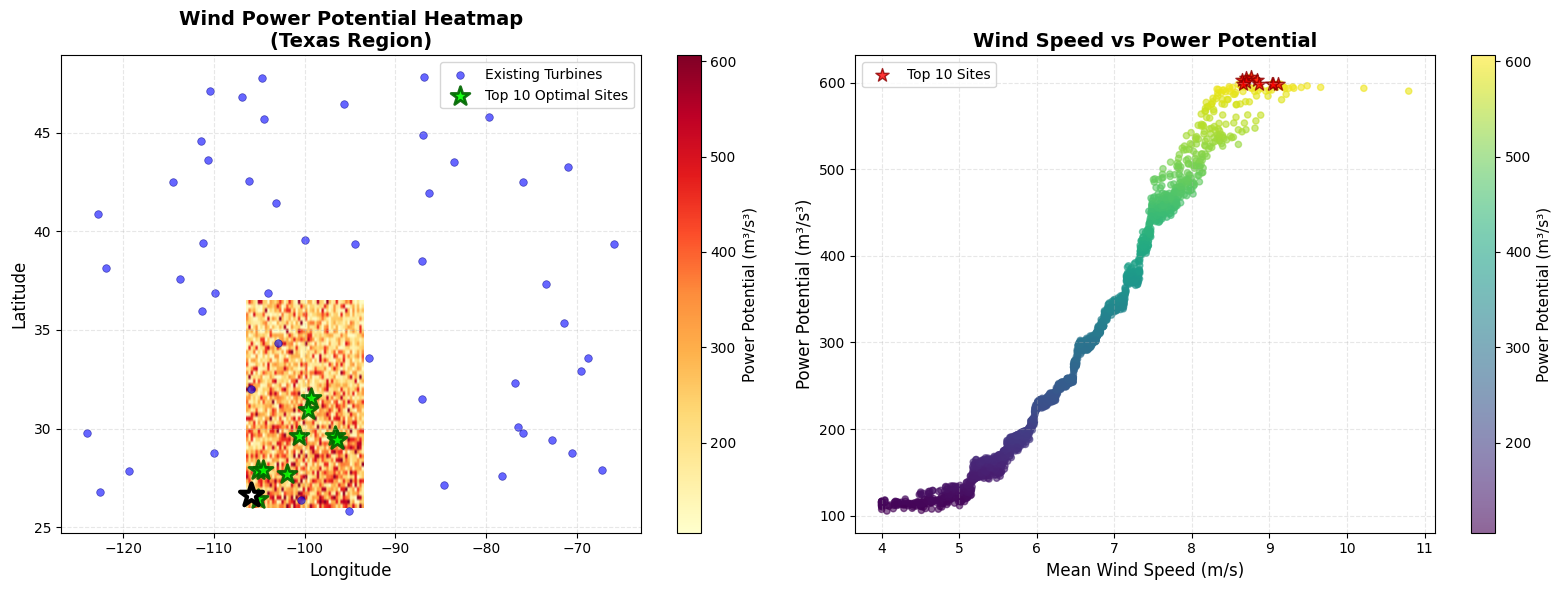

✅ Visualization complete!

💡 RECOMMENDATIONS:
  • Best single location: (26.6429, -105.9694)
  • Expected power potential: 606.36 m³/s³
  • Consider clustering turbines in the high-potential zone
  • Ensure minimum 4.4 km spacing between turbines


In [4]:
# 9️⃣ VISUALIZE OPTIMAL LOCATIONS
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

print("\n📈 Creating visualization...")

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Reshape data for heatmap
power_grid = np.array(results_df['power_potential'].values).reshape(grid_resolution, grid_resolution)

# Plot 1: Power Potential Heatmap
im1 = axes[0].imshow(power_grid, 
                      extent=[lon_min, lon_max, lat_min, lat_max],
                      origin='lower',
                      cmap='YlOrRd',
                      aspect='auto')
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].set_title('Wind Power Potential Heatmap\n(Texas Region)', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Power Potential (m³/s³)', fontsize=11)

# Mark existing turbines
if len(turbines) > 0:
    axes[0].scatter(turbines['xlong'], turbines['ylat'], 
                   c='blue', s=30, alpha=0.6, marker='o', 
                   label='Existing Turbines', edgecolors='darkblue', linewidth=0.5)

# Mark top 10 optimal locations
axes[0].scatter(top_locations['lon'], top_locations['lat'],
               c='lime', s=200, alpha=0.9, marker='*',
               label='Top 10 Optimal Sites', edgecolors='darkgreen', linewidth=2)

# Mark the #1 location specially
best = top_locations.iloc[0]
axes[0].scatter(best['lon'], best['lat'],
               c='white', s=300, alpha=1, marker='*',
               edgecolors='black', linewidth=3, zorder=10)

axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Plot 2: Scatter plot - Wind Speed vs Power Potential
scatter = axes[1].scatter(results_df['mean_wind_speed'], 
                          results_df['power_potential'],
                          c=results_df['power_potential'],
                          cmap='viridis',
                          alpha=0.6,
                          s=20)
axes[1].set_xlabel('Mean Wind Speed (m/s)', fontsize=12)
axes[1].set_ylabel('Power Potential (m³/s³)', fontsize=12)
axes[1].set_title('Wind Speed vs Power Potential', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

# Highlight top locations
axes[1].scatter(top_locations['mean_wind_speed'], 
               top_locations['power_potential'],
               c='red', s=100, alpha=0.8, marker='*',
               edgecolors='darkred', linewidth=1,
               label='Top 10 Sites')
axes[1].legend(fontsize=10)

cbar2 = plt.colorbar(scatter, ax=axes[1])
cbar2.set_label('Power Potential (m³/s³)', fontsize=11)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")
print(f"\n💡 RECOMMENDATIONS:")
print(f"  • Best single location: ({best['lat']:.4f}, {best['lon']:.4f})")
print(f"  • Expected power potential: {best['power_potential']:.2f} m³/s³")
print(f"  • Consider clustering turbines in the high-potential zone")
print(f"  • Ensure minimum {results_df['nearest_turbine_km'].min():.1f} km spacing between turbines")


In [7]:
# 🔟 EXPORT RESULTS
print("\n💾 Exporting results...")

# Export top locations to CSV
output_file = 'optimal_wind_turbine_locations.csv'
top_locations.to_csv(output_file, index=False)
print(f"✓ Top {top_n} locations saved to: {output_file}")

# Also export all candidates for further analysis
all_results_file = 'all_candidate_locations.csv'
results_df.to_csv(all_results_file, index=False)
print(f"✓ All {len(results_df)} candidate locations saved to: {all_results_file}")

# Create a summary report
summary_file = 'wind_optimization_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("WIND TURBINE LOCATION OPTIMIZATION REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Search Region: Texas ({lat_min}° to {lat_max}° N, {lon_min}° to {lon_max}° W)\n")
    f.write(f"Grid Resolution: {grid_resolution}x{grid_resolution} ({grid_resolution**2} locations evaluated)\n\n")
    
    f.write(f"TOP {top_n} OPTIMAL LOCATIONS:\n")
    f.write("-"*80 + "\n")
    for idx, (i, row) in enumerate(top_locations.iterrows(), 1):
        f.write(f"\nRank #{idx}:\n")
        f.write(f"  Latitude:  {row['lat']:.6f}°\n")
        f.write(f"  Longitude: {row['lon']:.6f}°\n")
        f.write(f"  Power Potential: {row['power_potential']:.2f} m³/s³\n")
        f.write(f"  Mean Wind Speed: {row['mean_wind_speed']:.2f} m/s\n")
        f.write(f"  Distance to Nearest Turbine: {row['nearest_turbine_km']:.1f} km\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("STATISTICAL SUMMARY\n")
    f.write("="*80 + "\n")
    f.write(f"Average Power Potential: {results_df['power_potential'].mean():.2f} m³/s³\n")
    f.write(f"Maximum Power Potential: {results_df['power_potential'].max():.2f} m³/s³\n")
    f.write(f"Minimum Power Potential: {results_df['power_potential'].min():.2f} m³/s³\n")
    f.write(f"Standard Deviation: {results_df['power_potential'].std():.2f} m³/s³\n\n")
    
    f.write("HIGH-POTENTIAL ZONE (Top 10%):\n")
    f.write(f"  Number of Sites: {len(high_potential)}\n")
    f.write(f"  Latitude Range: {high_potential['lat'].min():.4f}° to {high_potential['lat'].max():.4f}°\n")
    f.write(f"  Longitude Range: {high_potential['lon'].min():.4f}° to {high_potential['lon'].max():.4f}°\n")
    f.write(f"  Average Power Potential: {high_potential['power_potential'].mean():.2f} m³/s³\n")

print(f"✓ Summary report saved to: {summary_file}")

print("\n" + "="*80)
print("🎉 WIND TURBINE OPTIMIZATION COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print(f"  1. {output_file} - Top {top_n} locations with coordinates")
print(f"  2. {all_results_file} - All evaluated locations")
print(f"  3. {summary_file} - Detailed text report")
print("\n💡 Next Steps:")
print("  • Review the heatmap to identify optimal zones")
print("  • Consider environmental and regulatory constraints")
print("  • Perform on-site wind measurements at top locations")
print("  • Conduct economic feasibility analysis")
print("  • Evaluate grid connection availability")



💾 Exporting results...
✓ Top 10 locations saved to: optimal_wind_turbine_locations.csv
✓ All 2500 candidate locations saved to: all_candidate_locations.csv
✓ Summary report saved to: wind_optimization_summary.txt

🎉 WIND TURBINE OPTIMIZATION COMPLETE!

Generated Files:
  1. optimal_wind_turbine_locations.csv - Top 10 locations with coordinates
  2. all_candidate_locations.csv - All evaluated locations
  3. wind_optimization_summary.txt - Detailed text report

💡 Next Steps:
  • Review the heatmap to identify optimal zones
  • Consider environmental and regulatory constraints
  • Perform on-site wind measurements at top locations
  • Conduct economic feasibility analysis
  • Evaluate grid connection availability


In [10]:
import pandas as pd
import numpy as np

# --- Example dataset (replace with your real results_df) ---
# This simulates 3 example turbine sites with mean wind speeds
results_df = pd.DataFrame({
    "lat": [31.9, 32.5, 33.1],
    "lon": [-99.8, -100.3, -98.9],
    "mean_wind_speed": [7.5, 8.6, 9.3]  # m/s
})

# --- 1️⃣ Convert mean wind speed → approximate Capacity Factor (CF)
results_df["cf_estimated"] = np.clip((results_df["mean_wind_speed"] - 3) / (13 - 3) * 0.5, 0, 0.5)

# --- 2️⃣ Function to compute economics ---
def compute_wind_metrics(cf, turbine_capacity=2.0, num_turbines=2,
                         capex_per_unit=1_500_000, om_cost_per_mw_yr=45_000,
                         price_per_kwh=0.05, lifespan=20):
    """
    cf: capacity factor (0–1)
    turbine_capacity: MW per turbine
    num_turbines: number of turbines
    capex_per_unit: construction cost per turbine ($)
    """
    total_mw = turbine_capacity * num_turbines
    annual_energy_kwh = total_mw * 1000 * 8760 * cf               # total yearly production
    annual_revenue = annual_energy_kwh * price_per_kwh            # gross revenue
    annual_om = total_mw * om_cost_per_mw_yr                      # yearly maintenance
    net_profit = annual_revenue - annual_om                       # profit after maintenance
    capex_total = num_turbines * capex_per_unit                   # total construction cost
    roi = (net_profit / capex_total) * 100                        # annual ROI %
    payback = capex_total / net_profit if net_profit > 0 else None
    lifetime_profit = net_profit * lifespan - capex_total
    return {
        "annual_energy_kwh": annual_energy_kwh,
        "annual_revenue": annual_revenue,
        "annual_profit": net_profit,
        "roi_percent": roi,
        "payback_years": payback,
        "lifetime_profit": lifetime_profit
    }

# --- 3️⃣ USER INPUTS (hard-coded for now; replace with Streamlit sliders later) ---
CONSTRUCTION_PER_UNIT = 1_500_000   # $1.5M
NUM_UNITS = 99                       # 2 turbines total
CAPACITY_FACTOR = 0.35              # average efficiency 35%

# --- 4️⃣ Apply to each site ---
econ_results = results_df.apply(
    lambda row: compute_wind_metrics(
        cf=CAPACITY_FACTOR,                     # user-specified CF
        num_turbines=NUM_UNITS,
        capex_per_unit=CONSTRUCTION_PER_UNIT
    ), axis=1
)

# Combine results
econ_df = pd.DataFrame(econ_results.tolist())
results_df = pd.concat([results_df, econ_df], axis=1)

# --- 5️⃣ Display nicely ---
def print_econ_summary(lat, lon, metrics):
    print(f"\n📍 Location: ({lat:.3f}, {lon:.3f})")
    print(f"{'Metric':<25} {'Calculation':<40} {'Result'}")
    print("-"*80)
    print(f"{'Annual Energy':<25} {NUM_UNITS}×2 MW × 8760 h × {CAPACITY_FACTOR:.2f} {'':<10} ≈ {metrics['annual_energy_kwh']/1e6:,.2f} MWh")
    print(f"{'Annual Revenue':<25} Energy × $0.05/kWh {'':<10} ≈ ${metrics['annual_revenue']:,.0f}")
    print(f"{'O&M Cost':<25} 2 MW × $45 000/MW × {NUM_UNITS} {'':<10} ≈ ${(2*45_000*NUM_UNITS):,.0f}")
    print(f"{'Net Annual Profit':<25} Revenue − O&M {'':<10} ≈ ${metrics['annual_profit']:,.0f}")
    print(f"{'Construction Cost':<25} {NUM_UNITS}×${CONSTRUCTION_PER_UNIT/1_000_000:.1f} M {'':<10} ≈ ${CONSTRUCTION_PER_UNIT*NUM_UNITS:,.0f}")
    print(f"{'ROI':<25} Profit ÷ Cost × 100 {'':<10} ≈ {metrics['roi_percent']:.1f}%/yr")
    print(f"{'Payback':<25} Cost ÷ Profit {'':<10} ≈ {metrics['payback_years']:.1f} yrs")

# --- 6️⃣ Print top 3 example results ---
for _, row in results_df.head(3).iterrows():
    metrics = row[["annual_energy_kwh", "annual_revenue", "annual_profit",
                   "roi_percent", "payback_years", "lifetime_profit"]].to_dict()
    print_econ_summary(row["lat"], row["lon"], metrics)



📍 Location: (31.900, -99.800)
Metric                    Calculation                              Result
--------------------------------------------------------------------------------
Annual Energy             99×2 MW × 8760 h × 0.35            ≈ 607.07 MWh
Annual Revenue            Energy × $0.05/kWh            ≈ $30,353,400
O&M Cost                  2 MW × $45 000/MW × 99            ≈ $8,910,000
Net Annual Profit         Revenue − O&M            ≈ $21,443,400
Construction Cost         99×$1.5 M            ≈ $148,500,000
ROI                       Profit ÷ Cost × 100            ≈ 14.4%/yr
Payback                   Cost ÷ Profit            ≈ 6.9 yrs

📍 Location: (32.500, -100.300)
Metric                    Calculation                              Result
--------------------------------------------------------------------------------
Annual Energy             99×2 MW × 8760 h × 0.35            ≈ 607.07 MWh
Annual Revenue            Energy × $0.05/kWh            ≈ $30,353,400
O&M Cost  